## Exercise 4: Logistic Regression, Bayes and EM
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

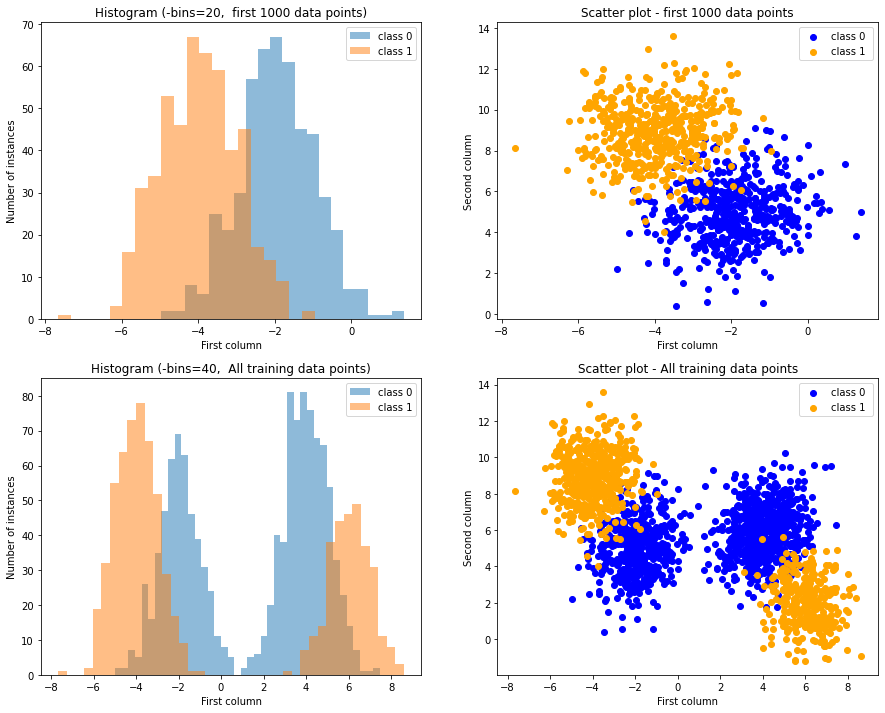

In [4]:
col_0_cls_0 = X_training[np.where(y_training[:1000] == 0)][:,0]
col_0_cls_1 = X_training[np.where(y_training[:1000] == 1)][:,0]

col_1_cls_0 = X_training[np.where(y_training[:1000] == 0)][:,1]
col_1_cls_1 = X_training[np.where(y_training[:1000] == 1)][:,1]

fig, ax = plt.subplots(2, 2)


#  histogram plot for first feature only
#  first 1000 data points
ax[0,0].hist(col_0_cls_0, bins=20, alpha=0.5)
ax[0,0].hist(col_0_cls_1, bins=20, alpha=0.5)
ax[0,0].set_title('Histogram (-bins=20,  first 1000 data points)')
ax[0,0].set_xlabel('First column')
ax[0,0].set_ylabel('Number of instances')
ax[0,0].legend(['class 0', 'class 1'])

# scatter plot for both feature 
# first 1000 data points
ax[0,1].scatter(col_0_cls_0, col_1_cls_0 , c='blue')
ax[0,1].scatter(col_0_cls_1, col_1_cls_1, c='orange')

ax[0,1].set_title('Scatter plot - first 1000 data points')
ax[0,1].set_xlabel('First column')
ax[0,1].set_ylabel('Second column')
ax[0,1].legend(['class 0 ', 'class 1'])

col_0_cls_0 = X_training[np.where(y_training == 0)][:,0]
col_0_cls_1 = X_training[np.where(y_training == 1)][:,0]

col_1_cls_0 = X_training[np.where(y_training == 0)][:,1]
col_1_cls_1 = X_training[np.where(y_training == 1)][:,1]

# histogram plot for the first feature
# all data points
ax[1,0].hist(col_0_cls_0, bins=40, alpha=0.5)
ax[1,0].hist(col_0_cls_1, bins=40, alpha=0.5)
ax[1,0].set_title('Histogram (-bins=40,  All training data points)')
ax[1,0].set_xlabel('First column')
ax[1,0].set_ylabel('Number of instances')
ax[1,0].legend(['class 0', 'class 1'])

# scatter plot for both feature
# all data points
ax[1,1].scatter(col_0_cls_0, col_1_cls_0 , c='blue')
ax[1,1].scatter(col_0_cls_1, col_1_cls_1, c='orange')

ax[1,1].set_title('Scatter plot - All training data points')
ax[1,1].set_xlabel('First column')
ax[1,1].set_ylabel('Second column')
ax[1,1].legend(['class 0 ', 'class 1'])

fig.set_size_inches(15, 12)
plt.show()

## Logistic Regression


Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = []
        self.num_featurers = 0

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        self.num_features = X.shape[1]
        
        X = np.column_stack((np.ones(X.shape[0]), X))
            
        m = X.shape[1] 
        N = X.shape[0]
        J_history = [-1]
        
        #preprocessing
        rgen = np.random.RandomState(self.random_state)
        self.theta = rgen.normal(loc=0.0, scale=1, size=m)
        
        for i in range(self.n_iter):
            
            # compute hypothesis  
            calc1 = np.exp(-np.dot(X, self.theta))
            h = 1 / (1 + calc1)
            
            # update theta 
            self.theta = self.theta - (self.eta * np.dot(X.T, h-y))
            
            #compute_cost
            j = (1/m) * np.sum([(-y *np.log(h)) - ((1-y)* np.log(1-h))])
            J_history.append(j)
            
            # stop if difference between two iterations < eps 
            if np.abs(J_history[-2] - J_history[-1]) <= self.eps:
                break
            
        return J_history[1:]
    
    def predict(self, X):
        """Return the predicted class label"""
        self.theta = np.array(self.theta)
        preds = np.zeros(shape=X.shape[0])
        
        # one instance
        if X.size == self.num_features:
            X = np.insert(X, 0, 1)
        else:
        # number of instances > 1
            X = np.column_stack((np.ones(X.shape[0]), X))
        
        calc1 = np.exp(-np.dot(X, self.theta))
        h = 1 / (1 + calc1)
        
        preds[np.where(h >= 0.5)] = 1
        
        return preds

## Cross Validation

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [6]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

shuffled_train= training_set.values
np.random.shuffle(shuffled_train)
X_shuffled_train = shuffled_train[:, : -1]
y_shuffled_train = shuffled_train[:, -1]

X_split_data = np.array_split(X_shuffled_train, 5)
y_split_data = np.array_split(y_shuffled_train, 5)

best_eta = 0;
best_eps = 0;
min_cost = float('inf')

for eta in etas:
    eta_epss_costs = []
    for epsilon in epss:
        five_costs = []
        Lor = LogisticRegressionGD(eta=eta, eps=epsilon)
        for i in range(5):
            J = Lor.fit(X_split_data[i], y_split_data[i])
            five_costs.append(J[-1])
        avg_eta_eps_cost = sum(five_costs) / 5
        if avg_eta_eps_cost < min_cost:
            min_cost = avg_eta_eps_cost
            best_eta = eta
            best_eps = epsilon

In [7]:
print(f'(best_eta, best_eps)= ({best_eta}, {best_eps})')

(best_eta, best_eps)= (5e-05, 1e-06)


## Normal distribution pdf


Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [8]:
def norm_pdf(data, mu, sigma):
    calc1 = 1 / sigma * np.sqrt(2 * np.pi)
    calc2 = np.exp((-1 / 2) * np.square(np.divide(data - mu, sigma)))
    return calc1 * calc2

## Expectation Maximization

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [9]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        
        self.rs = []
        self.ws = []
        self.mus = []
        self.sigmas = []
    
    
    def init_params(self, data):
        """
        Initialize distribution params
        
        Input: 
        data - data of one feature(column) from all data
        """
        
        self.ws = np.full(self.k, 1 / self.k)
        data = np.sort(data)
        
        gap = int(len(data)/ self.k)
        
        for j in range(self.k):
            start = j * gap
            end = start + gap
            self.mus.append(np.mean(data[start : end]))
            self.sigmas.append(np.std(data[start :end]))
    
        self.mus = np.array(self.mus)
        self.sigmas = np.array(self.sigmas)
    
    
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
       
        ps = [self.ws[j] * norm_pdf(data, self.mus[j], self.sigmas[j]) for j in range(self.k)]
        sum_ps_by_row = np.sum(ps, axis=0)
        self.rs = ps / sum_ps_by_row
    
            
    def maximization(self, data):
        """
        M step - updating distribution params
        """
        N = data.shape[0]
        
        for j in range(self.k):
            self.ws[j] = np.sum(self.rs[j], axis=0) / N
            self.mus[j] = np.sum(self.rs[j] * data) / (self.ws[j] * N)
            self.sigmas[j] = np.sqrt(np.sum(self.rs[j] * np.square(data - self.mus[j])) / (self.ws[j] * N))
       
    
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        curr_cost = -1
        
        for i in range(self.n_iter):

            self.expectation(data)
            self.maximization(data)
            
            prev_cost = curr_cost
            # sum the cost of all gaussians 
            curr_cost = np.sum(np.sum([-1 * np.log(self.ws[j] * norm_pdf(data, self.mus[j], self.sigmas[j])) for j in range(self.k)]))
            if (np.abs(prev_cost - curr_cost) <= self.eps):
                break
            
            
    def get_dist_params(self):
        """
        Return the current distribution parameters (- fit the data before using)
        """
        
        return self.ws, self.mus, self.sigmas

## Naive Bayes

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [10]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.priors = []
        self.params = []
        self.num_features = 0
        
    
    def compute_prior(self, y):
        """
        compute the prior of each class
        priors[0] = prior of class 0 , priors[1] = prior of class 1 
        """
        _, counts = np.unique(y, return_counts= True)
        data_size = len(y)
        self.priors = [counts[0] / data_size, counts[1] / data_size]
        
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.num_features = X.shape[1]
        
        self.compute_prior(y)
        
        data_given_cls_0 = X[np.where(y == 0)]
        data_given_cls_1 = X[np.where(y == 1)]
            
        for i in range(X.shape[1]):
            em_0 = EM(k=self.k)
            em_1 = EM(k=self.k)
            
            em_0.fit(data_given_cls_0[:, i])
            em_1.fit(data_given_cls_1[:, i])
            
             # self.params = [(gussians params for feature i give class 0, gussians params for feature i give class 1)]
            self.params.append((em_0.get_dist_params(), em_1.get_dist_params()))
            
            
    def compute_likelihoods(self, X, class_value):
        """
        compute the likelihood for each instance in the data given the class value
        
        Inputs:
        X - the data
        class_value - the class to consider
        
        Returns:
        return likelihood for each instance in the data(X)
        """
        likelihoods = []
        
        # for each feature
        for i in range(X.shape[1]):
                ws, mus, sigmas = self.params[i][class_value]
                curr_likelihood = np.sum([[ws[j] * norm_pdf(X[:,i], mus[j], sigmas[j])] for j in range(self.k)], axis=0)[0]
                likelihoods.append(curr_likelihood)

        likelihoods = np.prod(likelihoods, axis=0)

        return likelihoods
    
    
    def get_instance_posterior(self, X, class_value):
        """
        compute the posterior for each instance in the data given the class value
        
        Inputs:
        X - the data
        class_value - the class to consider
        
        Returns:
        the posterior for each instance in the data(X)
        """
        return self.priors[class_value] * self.compute_likelihoods(X, class_value)
            
    
    def predict(self, X):
        """Return the predicted class label"""
        
        posterior_0 = self.get_instance_posterior(X, 0)
        posterior_1 = self.get_instance_posterior(X, 1)
    
        preds = np.zeros(shape=X.shape[0])
        preds[np.where((posterior_1 - posterior_0) > 0)] = 1
        
        return preds

## Model evaluation

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.


In [11]:
def accuracy_classifier(classifier, X, y, kind_of_data):
    """
    compute and print the accuracy of the given classifier on the given data
    
    Inputs:
    classifier - classifier to compute accuracy for
    X - the data (only features)
    y - labels 
    kind_of_data - which data is compute (for clearing print)
    """
    preds = classifier.predict(X)
    # num of true prdeictions / num of instances
    acc = np.count_nonzero((preds - y) == 0) / len(y)
    
    print(f'Accuracy on {kind_of_data} data: {acc}')

In [12]:
def plot_classifier(classifier, X, y, title):
    """
    plot the decision regions by the given classifier
    
    Inputs:
    classifier - classifier to plot his decision regions
    X - the data (only features)
    y - labels
    title - the title of the graph
    """
    plot_decision_regions(X, y, classifier)
    plt.title(title)
    plt.xlabel('First column')
    plt.ylabel('Second column')
    plt.legend(['blue - class 0', 'red - class 1'])
    plt.show()

In [13]:
def plot_LoR_costs(J_history, part_data):
    """
    plot LogisticRegression costs as function of iterstions
    
    Inputs:
    J_history - the costs of each step in LoR.fit
    part_data - string of the part of the data that LoR fit on (for clearing print) 
    """
    plt.plot(range(len(J_history)), J_history)
    plt.title(f'Logistic Regression - cost as function of iteration number ({part_data} data points)')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.show()

First 1000 data points 

Logistic Regression-
Accuracy on training data: 0.965
Accuracy on test data: 0.938

Naive Bayse Gaussian-
Accuracy on training data: 0.966
Accuracy on test data: 0.942


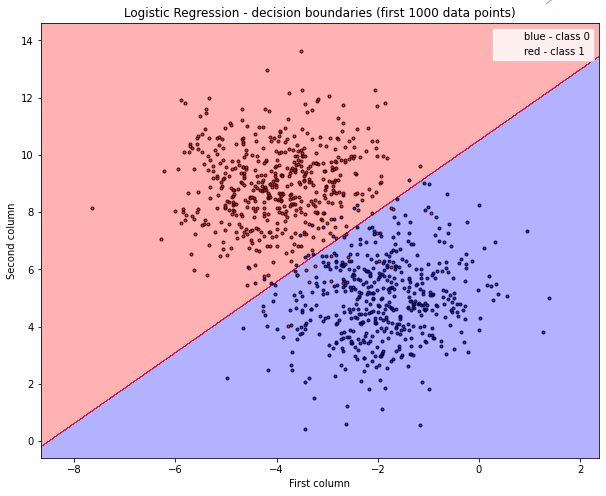

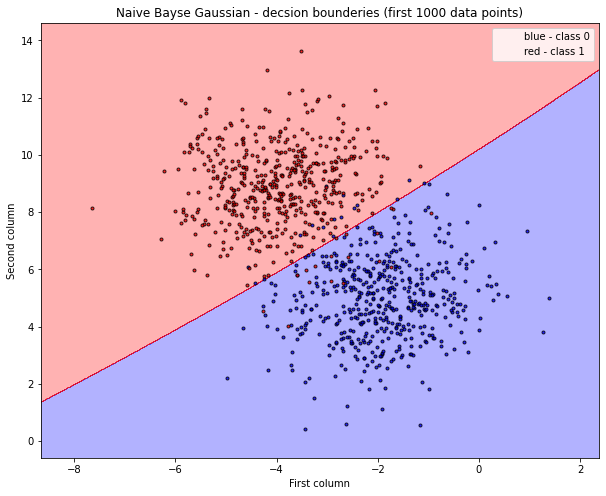

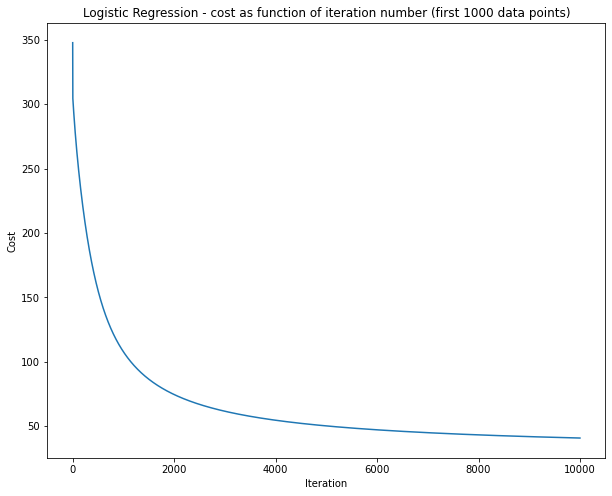

In [14]:
# first 1000 data points

LOR = LogisticRegressionGD( eta=best_eta, eps=best_eps)
J = LOR.fit(X_training[:1000], y_training[:1000])

NBG = NaiveBayesGaussian(k=1)
NBG.fit(X_training[:1000], y_training[:1000])

print(f'First 1000 data points \n')
#compute and print accuracy
print('Logistic Regression-')
accuracy_classifier(LOR, X_training[:1000], y_training[:1000], 'training')
accuracy_classifier(LOR, X_test[:500], y_test[:500], 'test')
print()

print('Naive Bayse Gaussian-')
accuracy_classifier(NBG, X_training[:1000], y_training[:1000], 'training')
accuracy_classifier(NBG, X_test[:500], y_test[:500], 'test')

#first 1000 training data points
title = 'Logistic Regression - decision boundaries (first 1000 data points)'
plot_classifier(LOR, X_training[:1000], y_training[:1000], title)

title = 'Naive Bayse Gaussian - decsion bounderies (first 1000 data points)' 
plot_classifier(NBG, X_training[:1000], y_training[:1000], title)

plot_LoR_costs(J, 'first 1000')

All data points 

Logistic Regression-
Accuracy on training data: 0.822
Accuracy on test data: 0.817

Naive Bayse Gaussian-
Accuracy on training data: 0.9215
Accuracy on test data: 0.902


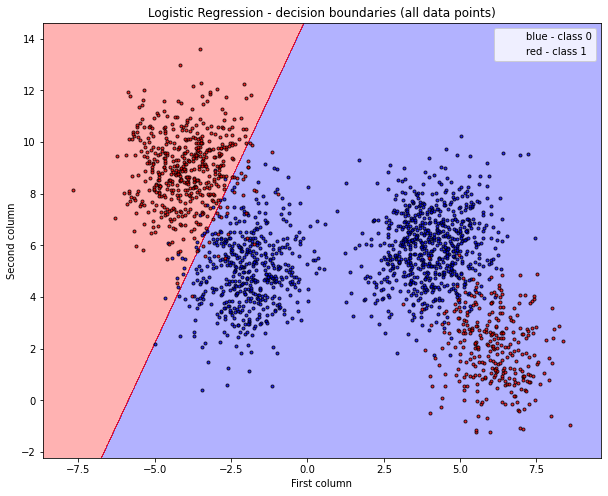

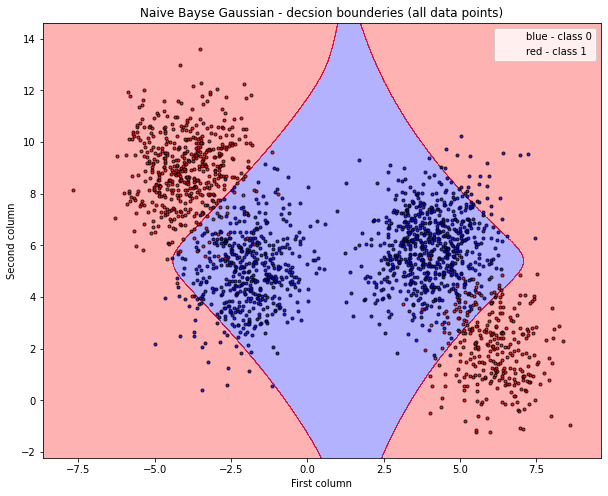

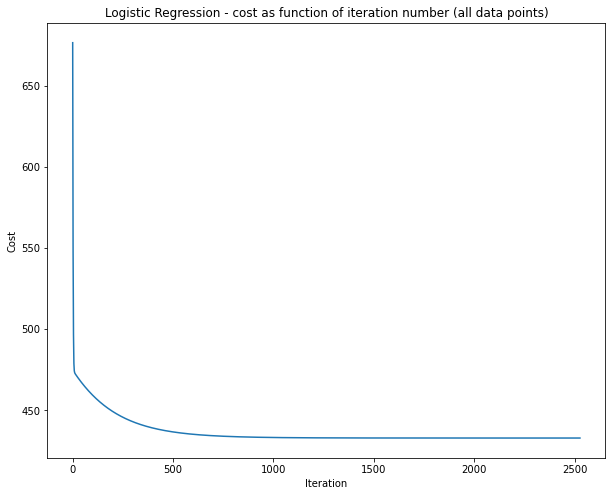

In [15]:
# all data points

LOR = LogisticRegressionGD( eta=best_eta, eps=best_eps)
J = LOR.fit(X_training, y_training)

NBG = NaiveBayesGaussian(k=2)
NBG.fit(X_training, y_training)

print('All data points \n')
#compute and print accuracy
print('Logistic Regression-')
accuracy_classifier(LOR, X_training, y_training, 'training')
accuracy_classifier(LOR, X_test, y_test, 'test')
print()

print('Naive Bayse Gaussian-')
accuracy_classifier(NBG, X_training, y_training, 'training')
accuracy_classifier(NBG, X_test, y_test, 'test')

#all data points 
title = 'Logistic Regression - decision boundaries (all data points)'
plot_classifier(LOR, X_training, y_training, title)

title = 'Naive Bayse Gaussian - decsion bounderies (all data points)' 
plot_classifier( NBG, X_training, y_training, title)

plot_LoR_costs(J, 'all')

# Logistic Regression - 

1. First 1000 data points:(graph 1)
The data is separatable then logistic regression works well - success to sperate the data. 
2. Cost as function of iterations (first 1000 data points):( Graph 3)
we can see that the cost improve as a function of the iterations, and converge between cost 40-50.
3. All data: (graph 4)
The data is not sperateable, the model has difficulty to deal with it and the sperate line is similar to the sperate line of the first 1000 data points which it is a bad preformance.  
4. Cost as function of iterations (all data points):( Graph 6)
The cost is improve as a function of the iterations but stop at high cost. Converge betwween cost 430-450. The reason is the same as we wrote at 3.

# Naive Bayse Gaussian-

1. First 1000 data points: 
The model successfully classified the data. The classifier uses separate by line, which is similar to the LoR graph.
2. All data :
The classifier separates the data differently and succeeds in separating the data into the 2 classes where the LoR fails. 

Both succeed since the marginal distrbution of the features (columns) of the data are different engough between the classes such that the Naive Bayse can separate them well

## Open question

1. In this exercise we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#  Naive Bayes will work better than Logisitc Regression

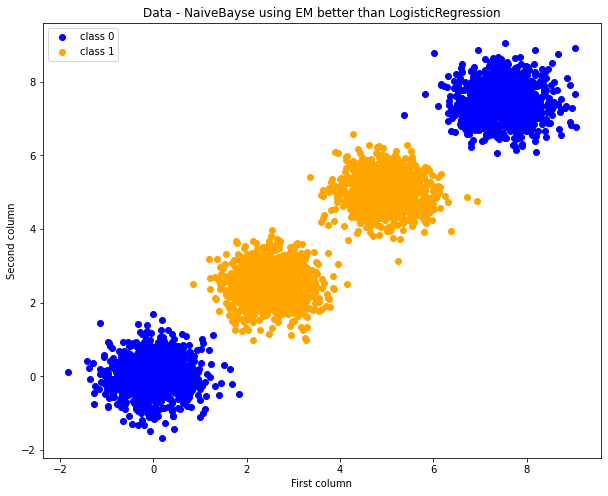

In [16]:
# Generate data s.t:
# Naive Bayse will work better than Logistic Regression
gaussian1_cls_0 = np.random.normal(loc=0.0, scale=0.5, size=(1000,2))
gaussian2_cls_0 = np.random.normal(loc=7.5, scale=0.5, size=(1000,2)) 

gaussian1_cls_1 = np.random.normal(loc=2.5, scale=0.5, size=(1000,2))
gaussian2_cls_1 = np.random.normal(loc=5.0, scale=0.5, size=(1000,2))

data_cls_0 = np.concatenate((gaussian1_cls_0, gaussian2_cls_0), axis=0)
data_cls_1 = np.concatenate((gaussian1_cls_1, gaussian2_cls_1), axis=0)

labels = np.concatenate((np.zeros(shape=(2000, 1)), np.ones(shape=(2000, 1))), axis=0)
data = np.concatenate((data_cls_0, data_cls_1), axis=0)
data = np.concatenate((data, labels), axis=1)

plt.scatter(data_cls_0[:,0], data_cls_0[:,1], color='blue')
plt.scatter(data_cls_1[:,0], data_cls_1[:,1], color='orange')
plt.title('Data - NaiveBayse using EM better than LogisticRegression')
plt.xlabel('First column')
plt.ylabel('Second column')
plt.legend(['class 0', 'class 1'])
plt.show()

Similar to the data we work on in the exercise. 
It is clear that the data is not separateable by linear line. Then, Linear regression may spearate between 2 gaussians and ignores the others. 
In addition the data points labels has different marginal distribution So naive bayse may work well. 

# Logistic Regression will work better than Naive Bayes using EM

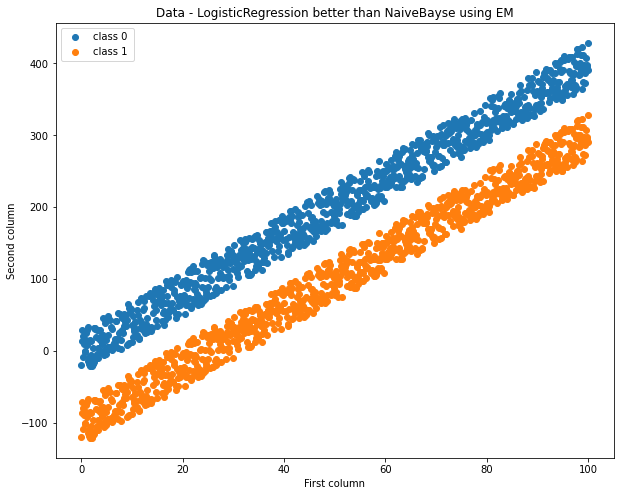

In [17]:
#Generate data s.t:
# Logistic Regression will work better than Naive Bayse

x = np.linspace(0, 100, 1000) # 1000 values between 0 and 100
delta = np.random.uniform(-30, 30, x.size)

y1 = 4*x  + delta
y2 = 4*x  + delta - 100 

x = x.reshape(x.shape[0], 1)
y1 = y1.reshape(y1.shape[0], 1)
y2 = y2.reshape(y2.shape[0], 1)

data_cls_0 = np.concatenate((x, y1), axis=1)
data_cls_1 = np.concatenate((x, y2), axis=1)

labels = np.concatenate((np.zeros(shape=(1000, 1)), np.ones(shape=(1000, 1))), axis=0)
data = np.concatenate((data_cls_0, data_cls_1), axis=0)
data = np.concatenate((data, labels), axis=1)

plt.scatter(x, y1)
plt.scatter(x, y2)
plt.title('Data - LogisticRegression better than NaiveBayse using EM')
plt.xlabel('First column')
plt.ylabel('Second column')
plt.legend(['class 0 ', 'class 1'])
plt.show()

It is clear that the data is linear separateable, then Lor may work well. 
When we can see that in the first column both classes have similar marginal distribution such that the they me be one on the other, so Naive Bayse may have diffictty to classify the data base on this feature(column). Also in the second feature(column) the marginal ditribution will be similar. Then, the result of NaiveBayse will not be good since the NaiveBayse assumption that the columns are independent and the difficult of NaiveBayse to deal with similar marginal distribution.